# Feature Selection

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


## 1. Load Data & Create the "Sanitary" Split

#### Description: 
This loads the data, converts dates, and creates a clean X_train dataframe containing ONLY numbers. It explicitly handles the case-sensitivity issue that caused your error.

In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import grangercausalitytests
import xgboost as xgb
import shap

# Load the Master Dataset
DATA_DIR = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Master_Dataset"
FILE_NAME = "master_dataset.csv"
df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME))
df['date'] = pd.to_datetime(df['date'])

# 2. Define Split (Strict Chronological)
TRAIN_END = "2019-12-31"
train_mask = df['date'] <= TRAIN_END
X_train_full = df[train_mask].copy()

# 3. Separate Target & Features
target_col = 'Log_Returns'  # Ensure this matches your column name exactly

# ROBUST SELECTION: Drop Date/Ticker by name, then force numeric types
# This prevents 'COP' or 'XOM' from crashing the math
cols_to_exclude = ['date', 'ticker', 'Date', 'Ticker', target_col]
feature_cols = [c for c in df.columns if c not in cols_to_exclude]

X_train = X_train_full[feature_cols].select_dtypes(include=[np.number]) 
y_train = X_train_full[target_col]

print(f"Training Data Shape: {X_train.shape}")
print("Sanity Check: Only numeric columns selected.")

Training Data Shape: (16674, 59)
Sanity Check: Only numeric columns selected.


## 2. The Spearman Correlation Filter

#### Description: 
This calculates the correlation matrix. We use Spearman (Rank) because it is less sensitive to financial outliers than Pearson. It automatically identifies features with >0.85 correlation.

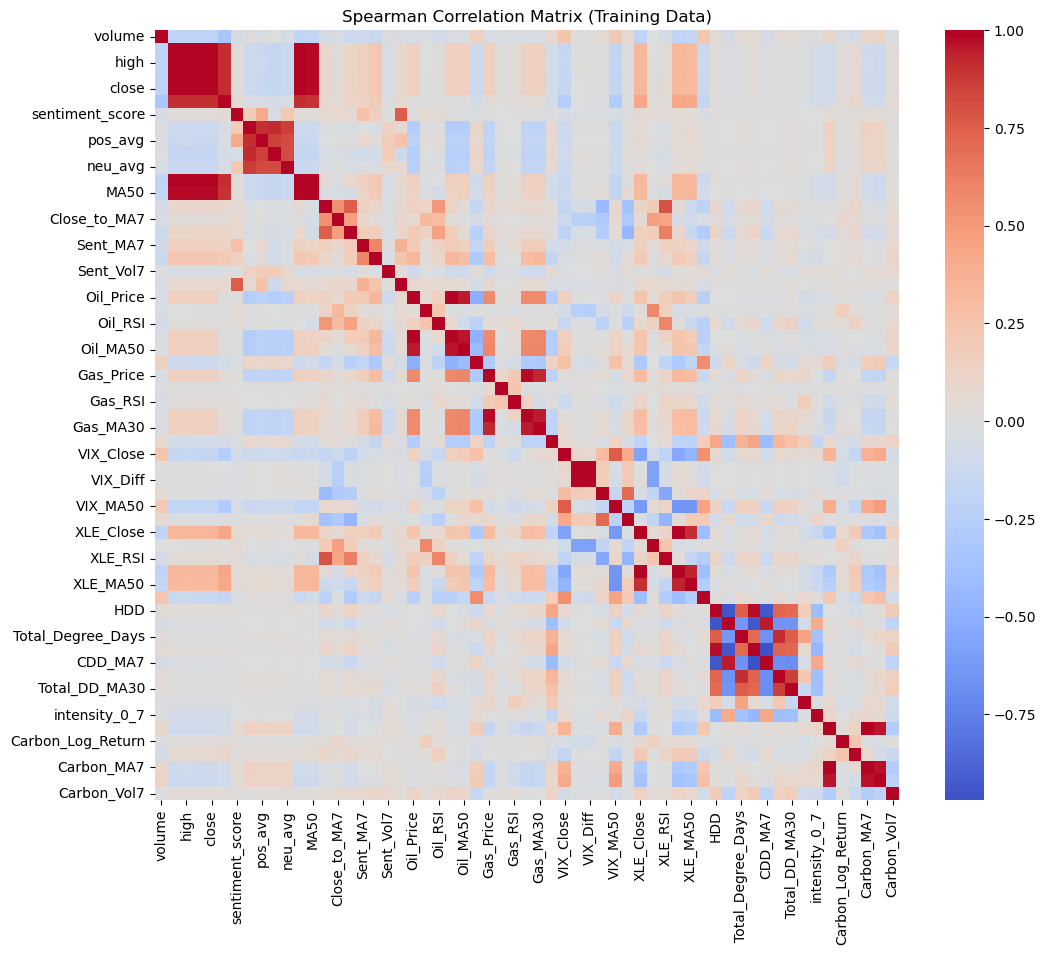

Features flagged for removal due to high correlation (> 0.85):
['high', 'low', 'close', 'adj close', 'pos_avg', 'neg_avg', 'neu_avg', 'MA7', 'MA50', 'Oil_MA7', 'Oil_MA50', 'Gas_MA7', 'Gas_MA30', 'VIX_Diff', 'XLE_MA7', 'XLE_MA50', 'CDD', 'HDD_MA7', 'CDD_MA7', 'Total_DD_MA7', 'Total_DD_MA30', 'Carbon_MA7', 'Carbon_MA50']


In [14]:
# Calculate Spearman Correlation Matrix
corr_matrix = X_train.corr(method='spearman')

# Plotting the Heatmap (Optional but recommended for visual inspection)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Spearman Correlation Matrix (Training Data)")
plt.show()

# Automated Redundancy Check
high_corr_threshold = 0.85
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features to drop
to_drop_corr = [column for column in upper.columns if any(upper[column].abs() > high_corr_threshold)]

print(f"Features flagged for removal due to high correlation (> {high_corr_threshold}):")
print(to_drop_corr)

## 3.  Variance Inflation Factor (VIF)

#### Description: 
This runs the Variance Inflation Factor test. We run this on a sample (first 5000 rows) to save time, as VIF is computationally heavy. Scores > 10 indicate dangerous redundancy.

In [17]:
# Drop the correlated columns first
X_vif = X_train.drop(columns=to_drop_corr)

# Handle Infinite values (common in financial ratios)
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna()

# Run VIF on a sample (Speed Optimization)
X_vif_sample = X_vif.sample(n=min(5000, len(X_vif)), random_state=42)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_sample.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_sample.values, i) for i in range(X_vif_sample.shape[1])]

print("Top 10 VIF Scores (High > 10 is bad):")
print(vif_data.sort_values(by="VIF", ascending=False).head(10))

Top 10 VIF Scores (High > 10 is bad):
              Feature         VIF
5        Close_to_MA7  966.525558
6       Close_to_MA50  689.098518
19          VIX_Close  491.123776
23        VIX_to_MA50  449.649219
22           VIX_MA50  436.936856
24          XLE_Close  147.134142
29  Total_Degree_Days   51.459009
26            XLE_RSI   45.439586
4                 RSI   38.980810
21            VIX_RSI   35.843319


## 4. Mutual Information (Non-Linear Signal)
#### Description: 
This calculates the dependency between every feature and the Target (Log Returns). Unlike correlation, this detects non-linear signals (e.g., volatility spikes).

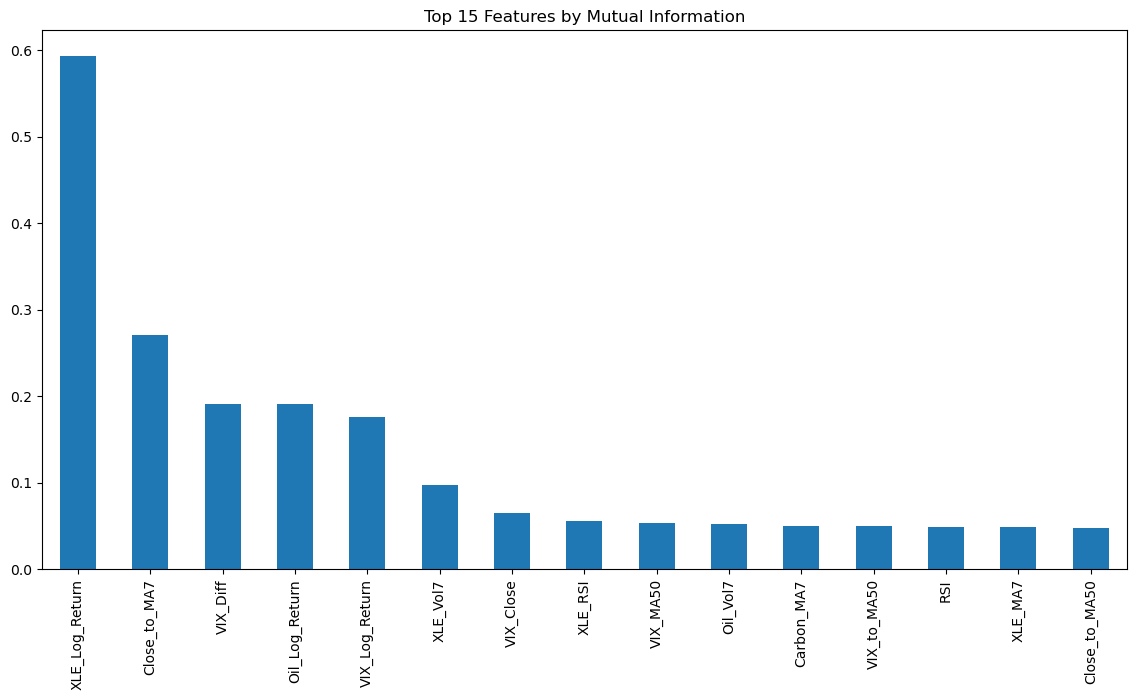

XLE_Log_Return    0.593562
Close_to_MA7      0.270355
VIX_Diff          0.191485
Oil_Log_Return    0.190806
VIX_Log_Return    0.175757
XLE_Vol7          0.097073
VIX_Close         0.065020
XLE_RSI           0.055822
VIX_MA50          0.053197
Oil_Vol7          0.051930
dtype: float64


In [22]:
# Calculate MI Scores
# We use fillna(0) because MI cannot handle NaNs
mi_scores = mutual_info_regression(X_train.fillna(0), y_train)
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(14, 7))
mi_series.head(15).plot(kind="bar")
plt.title("Top 15 Features by Mutual Information")
plt.show()

print(mi_series.head(10))

## 5. Granger Causality Test

#### Description: 
This performs a statistical hypothesis test to see if past values of a feature forecast the Target (Log Returns). We test lags up to 5 days. A p-value < 0.05 suggests the feature contains unique predictive signals that "cause" the target to move.

In [25]:
from statsmodels.tsa.stattools import grangercausalitytests

# Settings
max_lag = 5  # Check if the feature predicts the target within 1 week (5 trading days)
granger_results = {}

print(f"Running Granger Causality Tests (Max Lag: {max_lag})...")
print("Note: This test assumes stationarity. We use it here as a preliminary signal check.\n")

# Loop through all numeric features in X_train
for col in X_train.columns:
    try:
        # Prepare small dataframe [Target, Feature]
        # Granger function requires the Target to be the first column
        temp_df = pd.concat([y_train, X_train[col]], axis=1).dropna()
        
        # Run test (verbose=False suppresses massive output)
        # We look at the 'ssr_chi2test' (Chi-Squared) p-value
        gc_res = grangercausalitytests(temp_df, max_lag, verbose=False)
        
        # Extract the minimum p-value across all 5 lags (did ANY lag work?)
        min_p_value = min([gc_res[i+1][0]['ssr_chi2test'][1] for i in range(max_lag)])
        granger_results[col] = min_p_value
        
    except Exception as e:
        # This catches errors if a column is constant (0 variance) or has infinite values
        granger_results[col] = 1.0 

# Filter for Significant Features (p < 0.05)
passed_granger = [k for k, v in granger_results.items() if v < 0.05]
granger_series = pd.Series(granger_results).sort_values()

print(f"Features passing Granger Causality (p < 0.05): {len(passed_granger)}")
print("-" * 50)
print(granger_series.head(10))  # Show top 10 strongest causal features

Running Granger Causality Tests (Max Lag: 5)...
Note: This test assumes stationarity. We use it here as a preliminary signal check.



C:\Users\siddh\anaconda3\envs\sidd_ds\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\siddh\anaconda3\envs\sidd_ds\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\siddh\anaconda3\envs\sidd_ds\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\siddh\anaconda3\envs\sidd_ds\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\siddh\anaconda3\envs\sidd_ds\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\siddh\anaconda3\envs\sidd_ds\Lib\site-packages\statsmodels\ts

Features passing Granger Causality (p < 0.05): 48
--------------------------------------------------
Oil_Log_Return       9.028387e-13
VIX_Diff             1.476641e-12
XLE_MA7              3.247367e-11
VIX_Close            3.532945e-11
XLE_Close            7.701207e-11
Total_Degree_Days    1.257908e-10
Weather_Shock        9.144428e-10
XLE_MA50             2.691768e-09
XLE_Vol7             5.038569e-09
Oil_Price            5.468230e-09
dtype: float64


## 6. XGBoost + SHAP (The Final Judge)

#### Description: 
This trains a gradient boosting model to predict returns and uses SHAP values to explain EXACTLY which features the model found useful. This is your "Feature Selection Truth."

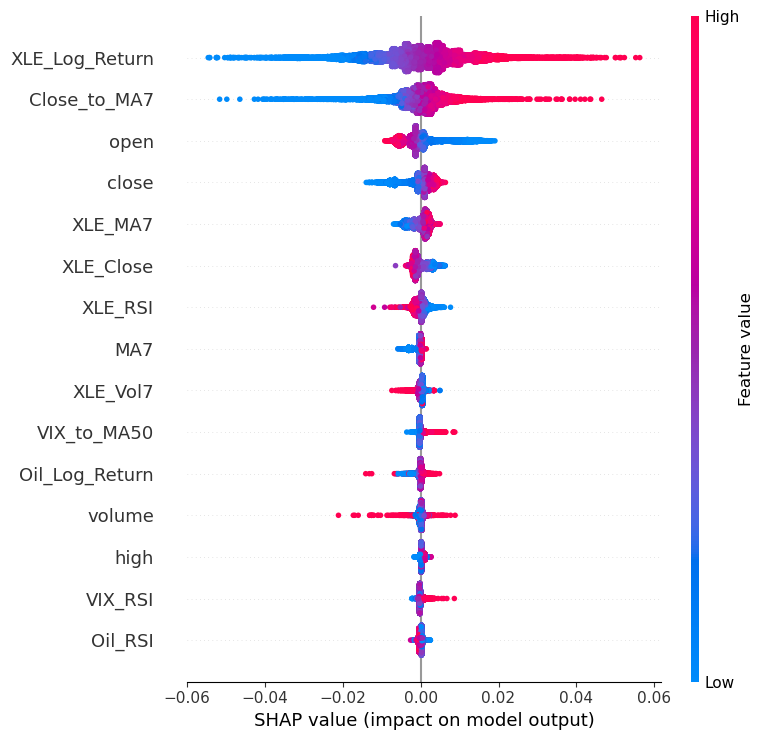

In [28]:
# Train XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=4)
model.fit(X_train, y_train)

# Calculate SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Plot Summary
plt.figure()
shap.summary_plot(shap_values, X_train, max_display=15)